<h1> Test Técnico FID Seguros </h1>

<h3> Autor: Pablo Calcumil Alarcón </h3>

<hr>

### ___Parte 2___

La viña “_Condorito_" es ampliamente reconocida como una de las mejores en el mundo, y posee una rica historia que nace en el año 1638. La calidad de la cosecha tiene un gran impacto en el valor de comercialización del vino, pudiendo llegar a costar miles de dólares. Muchos han investigado el efecto del momento en que se realiza la cosecha sobre la calidad del vino, pero un aspecto menos explorado es el efecto que tienen las lluvias durante el tiempo de la cosecha sobre la misma. La descripción de los datos es el siguiente:

<br>

<div align="center" style="font-size: 150%">
<table>
  <thead>
    <tr>
    </tr>
  </thead>
  <thead>
    <tr>
      <td rowspan=4><strong>Variable </strong></td>
      <td rowspan=4><strong>Descripción </strong></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan=4><strong>cosecha</strong></td>
      <td rowspan=4>Año de la cosecha</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td rowspan=4><strong>calidad</strong></td>
      <td rowspan=4>Puntaje asignado a la calidad de la cosecha</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td rowspan=4><strong>dias</strong></td>
      <td rowspan=4>Número de días, a partir del 31 de agosto, que finalizó la cosecha</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td rowspan=4><strong>lluvia</strong></td>
      <td rowspan=4><strong>1</strong>: lluvia durante la cosecha, <strong>0</strong>: sin lluvia durante la cosecha</td>
    </tr>
  </tbody>
  <thead>
    <tr>
    </tr>
  </thead>
</table>
</div>

<br>
<br>

Construya un modelo lineal en ___Python___ (o ___R___) con los datos adjuntos _“CosechaCondorito.txt”_, tomando como target la ___calidad___ de la cosecha.
Realice los siguientes pasos:

1. Análisis descriptivo.
2. Si bien se pide ajustar explícitamente un modelo lineal, ¿Qué otro modelo sugeriría?
3. Ajuste el modelo lineal.
4. Chequee significancia estadística de los coeficientes.
5. Cuantifique el efecto de la lluvia/días sobre la cosecha.
6. Chequee los supuestos estadísticos del modelo, con sus respectivas pruebas de hipótesis.
7. Chequee la bondad de ajuste de su modelo y compare con un modelo forward o
backward.
8. Conclusiones y recomendaciones a la viña _“Condorito”_ sobre la calidad de la cosecha.

### Desarrollo

In [1]:
#Conectando con Google Drive
from google.colab import drive
drive.mount('/content/drive/')
#Ruta de Trabajo
%cd /content/drive/MyDrive/Tareas_Varias/Tareas_Practicas/FID Seguros
#Archivos en Carpeta
%ls

Mounted at /content/drive/
/content/drive/MyDrive/Tareas_Varias/Tareas_Practicas/FID Seguros
 Cosecha_Condorito.txt
'Desafío reclutamiento FID Chile - Célula de Modelamiento y Analítica de Negocio.pdf'
 Prueba_Practica_FIDSeguros.ipynb


In [34]:
#Librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

In [ ]:
#Funcion grafico modelo lineal
def confidence_band(model, data, significancia = 0.05):
  #Se forma el dataframe predicciones con banda de confianza punto a punto
  predictions = model.get_prediction(exog = data).summary_frame(alpha = significancia)

  #Valores para formar grafico
  predictions['x'] = data.loc[:, 'dias'].to_numpy()
  predictions['y'] = data.calidad
  predictions['lluvia'] = data.lluvia.replace({0 : 'Sin lluvia', 1 : 'Con lluvia'})
  predictions = predictions.sort_values('x')

  #Grafico
  fig, ax = plt.subplots(1, 1, figsize = (18, 10))
  #Datos puntuales
  sns.scatterplot(data = predictions, x = 'x', y = 'y', hue = 'lluvia', palette = ['black', 'grey'], ax = ax)
  #Modelo lineal
  ax.plot(predictions['x'], predictions['mean'], linestyle = '-', label = 'OLS', linewidth = 2.5)
  #Banda de confianza
  ax.plot(predictions['x'], predictions['mean_ci_lower'], linestyle = '--', color = 'red', label = '95% CI')
  ax.plot(predictions['x'], predictions['mean_ci_upper'], linestyle = '--', color = 'red')
  ax.fill_between(predictions['x'], predictions['mean_ci_lower'], predictions['mean_ci_upper'], alpha = 0.1, color = 'r')
  #Custom
  ax.legend()
  ax.set_xlabel('Dias', fontsize = 12)
  ax.set_xlabel('Calidad', fontsize = 12)
  ax.set_title('Modelo Lineal y Banda de Confianza', fontsize = 15)
  ax.set_xlim(18, 57)
  ax.set_ylim(0, 6)
  plt.show()

#### 1. Realiza un análisis descriptivo.

In [3]:
#Leyendo dataframe desde un .txt
data = pd.read_csv('Cosecha_Condorito.txt', sep = '\t')
data.head()

,cosecha,calidad,dias,lluvia
0,1961,5.0,28,0
1,1962,4.0,50,0
2,1963,1.0,53,1
3,1964,3.0,38,0
4,1965,1.0,46,1


In [4]:
#Descripcion estadistica de variables numericas (Sacamos lluvia por ser binaria y cosecha pues es variable que solo indica el año)
data.drop(['cosecha', 'lluvia'], axis = 1).describe()

,calidad,dias
count,44.000000,44.000000
mean,3.159091,39.954545
std,1.301934,8.163887
min,1.000000,21.000000
25%,2.000000,34.250000
50%,3.500000,40.000000
75%,4.000000,46.250000
max,5.000000,54.000000


In [5]:
#Cantidad de datos y ver si tiene valores nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cosecha  44 non-null     int64  
 1   calidad  44 non-null     float64
 2   dias     44 non-null     int64  
 3   lluvia   44 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 1.5 KB


Notamos que el dataframe es de dimensiones (44, 4) y que no tiene valores nulos.

In [6]:
#Veamos como se distribuye la etiqueta lluvia
data.lluvia.value_counts(normalize = True)

0    0.568182
1    0.431818
Name: lluvia, dtype: float64

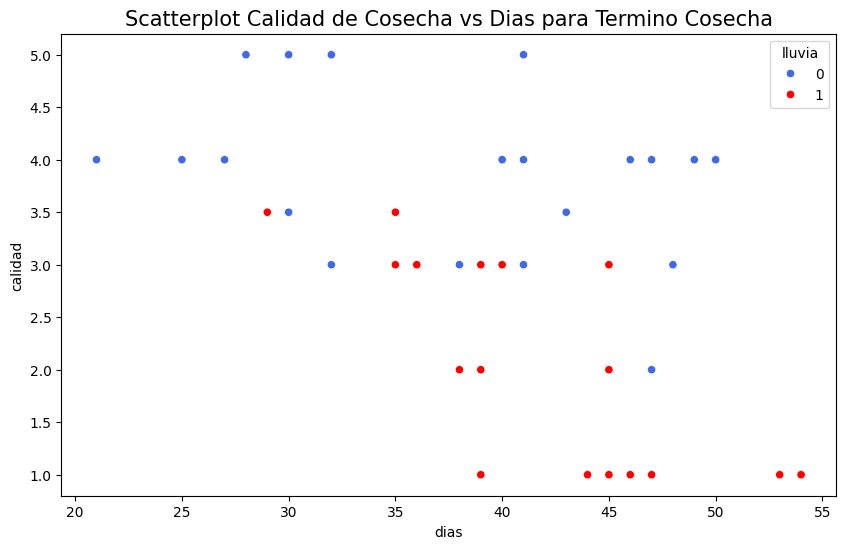

In [7]:
#Scatterplot calidad vs dias
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.scatterplot(data = data, x = 'dias', y = 'calidad', hue = 'lluvia', palette = ['royalblue', 'red'], ax = ax)
ax.set_title('Scatterplot Calidad de Cosecha vs Dias para Termino Cosecha', fontsize = 15)
plt.show()

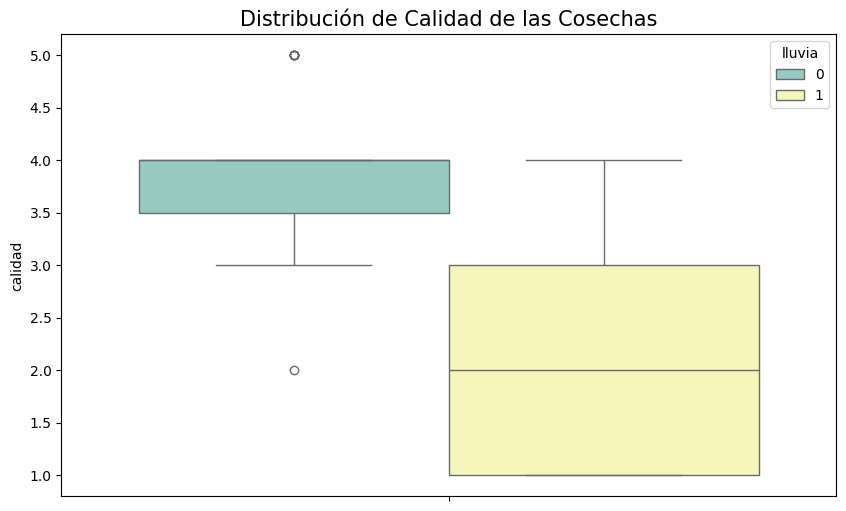

In [8]:
#Boxplots dispersion calidad cuando hubo o no lluvia
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.boxplot(data = data, y = 'calidad', hue = 'lluvia', ax = ax, palette = 'Set3')
ax.set_title('Distribución de Calidad de las Cosechas', fontsize = 15)
plt.show()

Con el scatterplot y el boxplot notamos que cuando ocurre el evento de lluvia afecta en la calidad de la cosecha.

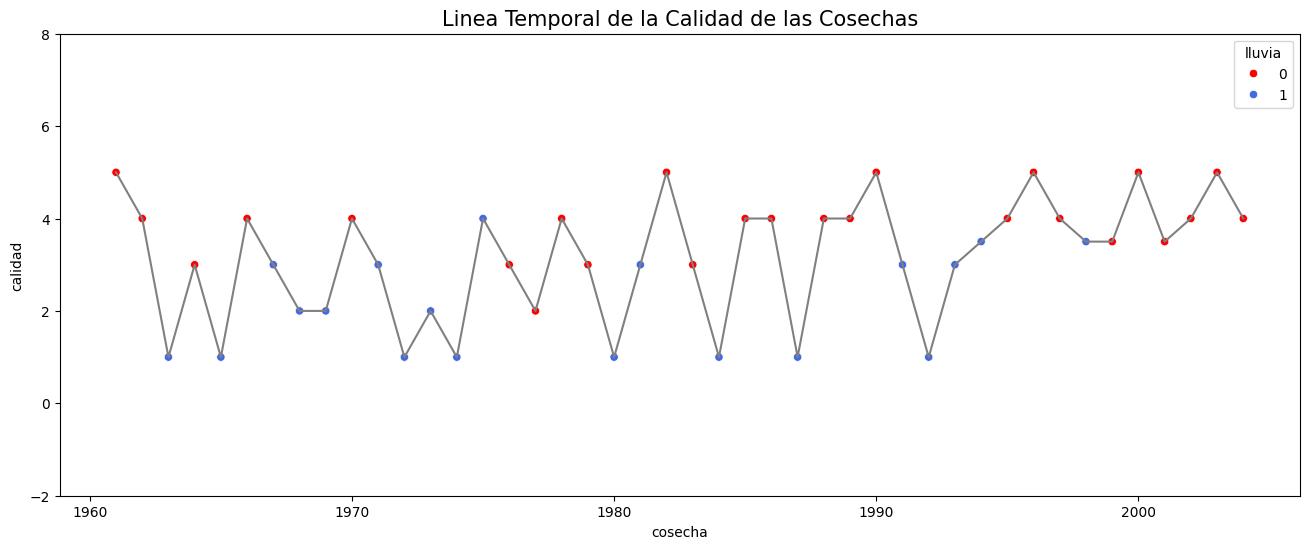

In [55]:
#Veamos como varia a lo largo de los años la calidad
fig, ax = plt.subplots(1, 1, figsize = (16, 6))
sns.lineplot(data = data, x = 'cosecha', y = 'calidad', color = 'grey', ax = ax)
sns.scatterplot(data = data, x = 'cosecha', y = 'calidad', hue = 'lluvia', palette = ['red', 'royalblue'], ax = ax)
ax.set_title('Linea Temporal de la Calidad de las Cosechas', fontsize = 15)
ax.set_ylim(-2, 8)
plt.show()

#### 2. Si bien se pide ajustar explícitamente un modelo lineal, ¿Qué otro modelo sugeriría?

> Un modelo recomendado para esta tarea podría ser un árbol de decisión regresivo, dato que la variable de lluvia es importante para calcular la calidad de la cosecha, entonces el modelo al notar que la variable de lluvia es $1$, comprendería rapidamente que la calidad tiene una baja considerable.


#### 3. Ajuste el modelo lineal.

Como se pudo notar en el análisis exploratorio, la variable `lluvia` influye notablemente en la variable de `calidad`, también se puede ver que mientras la cosecha se extiende por más días, menor calidad tendrá esta, lo mismo ocurre con la lluvia, es por ello que se agregará el termino de interacción entre `lluvia` y `dias`.

In [9]:
#Formula del modelo
ols_formula = 'calidad ~ C(lluvia) + dias'

#Eliminamos el año
X = data.drop('cosecha', axis = 1)

#Modelo
OLS = ols(formula = ols_formula, data = X)

#Ajustamos modelo
linear_model = OLS.fit()

#### 4. Chequee significancia estadística de los coeficientes.

In [11]:
#Revision de modelo y significancia estadistica de las variables
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     34.95
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.38e-09
Time:                        03:11:32   Log-Likelihood:                -51.645
No. Observations:                  44   AIC:                             109.3
Df Residuals:                      41   BIC:                             114.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.1463      0.619      9.

Notamos que las variables de `lluvia` y `dias``son estadísticamente significativas para el modelo lineal, esto pues, cada una tiene un $\text{p-value}< 0.05$. Por lo que se rechaza la hipótesis de que sus coeficientes deben ser 0, con un nivel de confianza del $95\%$.

#### 5. Cuantifique el efecto de la lluvia/días sobre la cosecha.

In [12]:
#Parametros (Coeficientes de las variables)
for variable in ['C(lluvia)[T.1]', 'dias']:
  print(f'Coeficiente del modelo lineal para la variable "{variable}": {round(linear_model.params.loc[variable], 4)}')
#Intercepto del modelo
print(f'El intercepto del modelo lineal: {round(linear_model.params.loc["Intercept"], 4)}')

Coeficiente del modelo lineal para la variable "C(lluvia)[T.1]": -1.6222
Coeficiente del modelo lineal para la variable "dias": -0.0572
El intercepto del modelo lineal: 6.1463


Esto quiere decir que el modelo lineal comienza con una calidad alta, donde cada día que pasa esta va disminuyendo en 0.06 aproximadamente. Por otro lado, si se presenta lluvia durante el período de cosecha, su calidad baja drasticamente en 1.6 aproximadamente.

#### 6. Chequee los supuestos estadísticos del modelo, con sus respectivas pruebas de hipótesis.

> Veamos el supuesto de linealidad

La correlación de Pearson entre las variables Calidad y Dias es: -0.5146


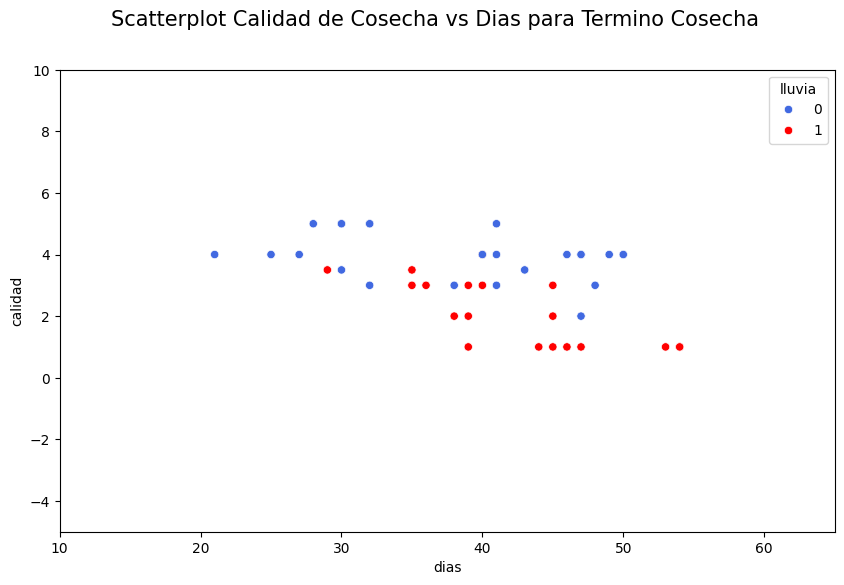

In [15]:
#Correlación de Pearson
print(f'La correlación de Pearson entre las variables Calidad y Dias es: {round(data.corr().loc["calidad", "dias"], 4)}')

#Scatterplot calidad vs dias
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.scatterplot(data = data, x = 'dias', y = 'calidad', hue = 'lluvia', palette = ['royalblue', 'red'], ax = ax)
plt.suptitle('Scatterplot Calidad de Cosecha vs Dias para Termino Cosecha', fontsize = 15)
plt.ylim(-5, 10)
plt.xlim(10, 65)
plt.show()

Notamos que la variable `dias`, no tiene una linealidad notoria respecto a la variable `calidad`. Además, al calcular el coeficiente de correlación de Pearson, se tiene un valor cercano a -0.5, lo que indica tener cierta linealidad (negativa), pero este valor sigue estando muy lejos de -1, por lo que no se puede decir que es completamente lineal.

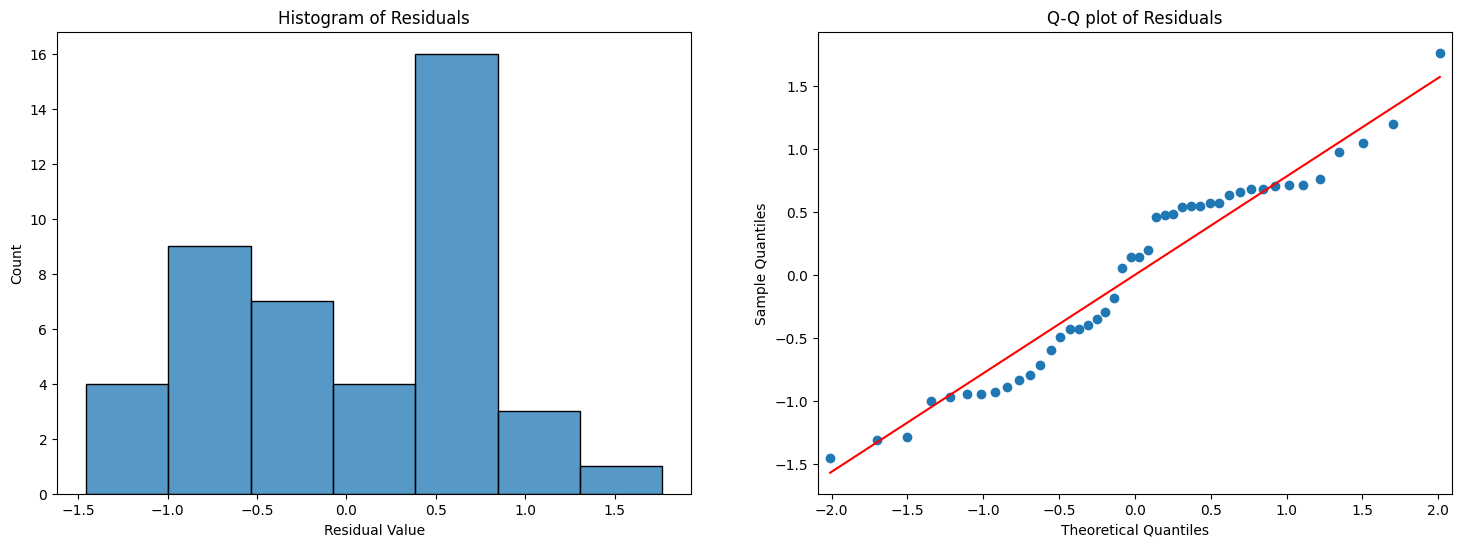

In [16]:
#Veamos el supuesto de Normalidad
#Obtenemos residuos del modelo
residuals = linear_model.resid

#Trazamos el histograma
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.histplot(residuals, ax = ax[0])
ax[0].set_xlabel('Residual Value')
ax[0].set_title('Histogram of Residuals')

#Trazamos Q-Q Plot
sm.qqplot(residuals, line = 's', ax = ax[1])
ax[1].set_title('Q-Q plot of Residuals')
plt.show()

Notamos también que el supuesto de normalidad tampoco se cumple, pues el histograma de los valores residuales del modelo no se parece en nada a la distribución Normal. Además se trazó el Q-Q plot, y se ve claramente que los valores están muy dispersos respecto a la diagonal.

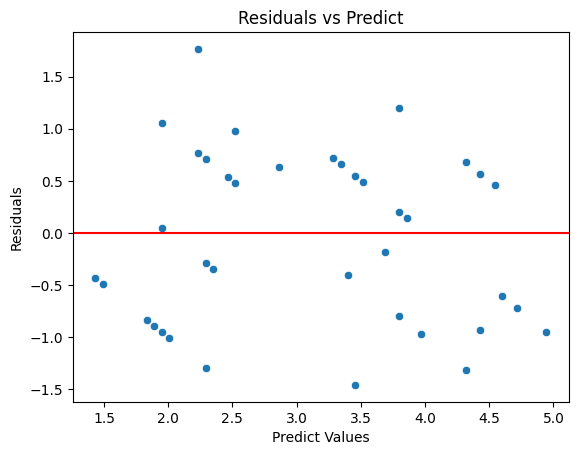

In [18]:
#Veamos el supuesto de Homocedasticidad
#Predecimos los valores con el modelo ajustado
y_predict = linear_model.predict(X)

#Formamos scatterplot residuos vs valores predichos
fig = sns.scatterplot(x = y_predict, y = residuals)
fig.axhline(0, color = 'r')
fig.set_xlabel('Predict Values')
fig.set_ylabel('Residuals')
fig.set_title('Residuals vs Predict')
plt.show()

#### 7. Chequee la bondad de ajuste de su modelo.

In [19]:
#Testeo de resultados
y = data.calidad
rmse = mean_squared_error(y_true  = y, y_pred  = y_predict, squared = False)
r2 = r2_score(y_true = y, y_pred = y_predict)
mae = mean_squared_error(y_true  = y, y_pred  = y_predict)
print(f"El error (RMSE) es: {round(rmse, 4)}")
print(f"El error (MAE) es: {round(mae, 4)}")
print(f"El coeficiente de determinación (r2) es: {round(r2, 4)}")

El error (RMSE) es: 0.7826
El error (MAE) es: 0.6124
El coeficiente de determinación (r2) es: 0.6303


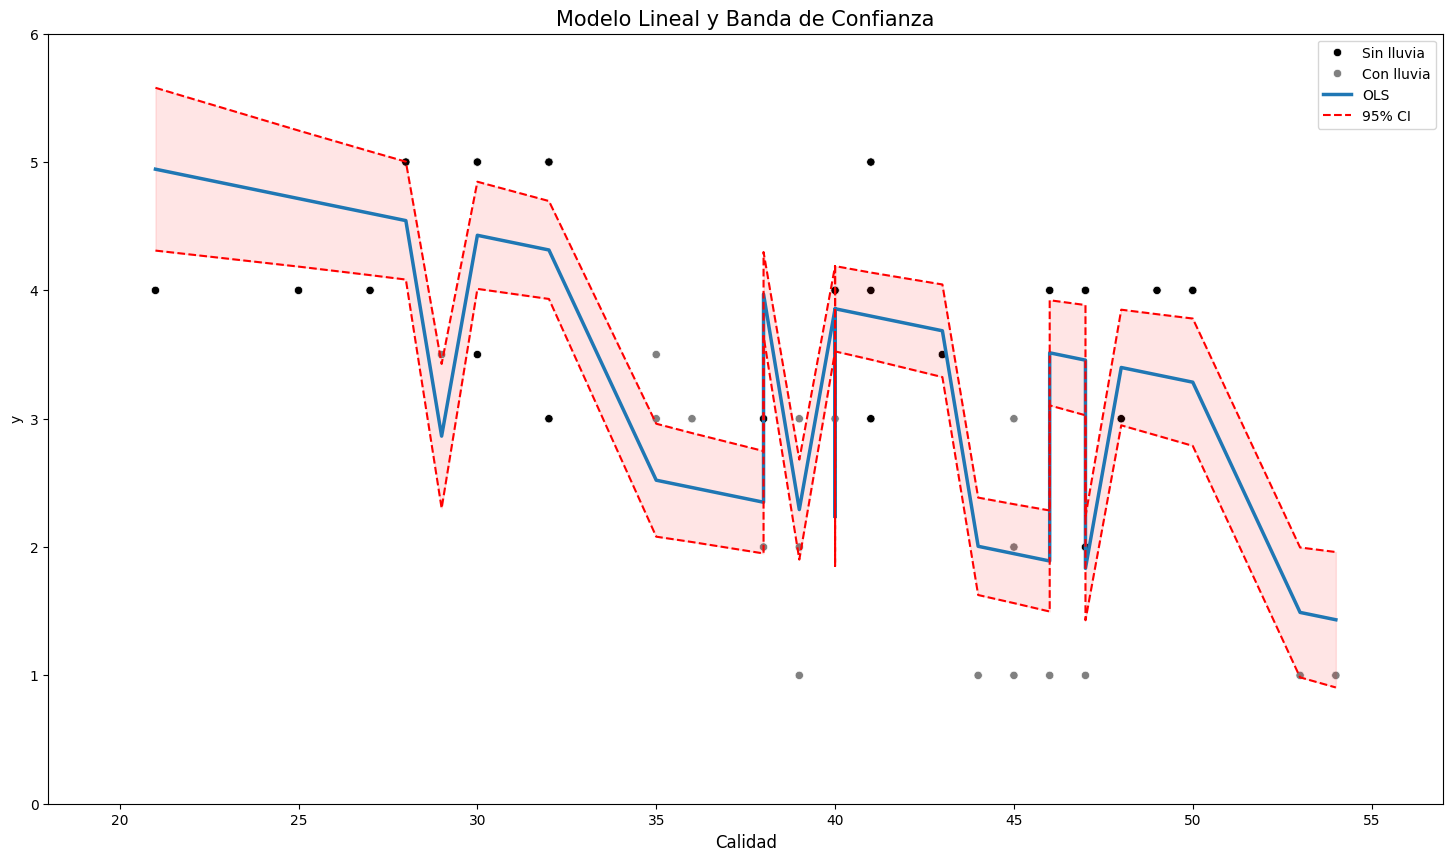

In [33]:
#Plot resultado Calidad vs Dias
confidence_band(linear_model, X)

Recordemos que el modelo de regresión que se ajustó, contiene 2 variables depedientes, es por ello que no se tiene "una linea", ya que este ajusta un hiperplano, pero el gráfico que estamos viendo solo lo vemos con la variable `dias` como variable dependiente.

In [35]:
#Veamos como actua la variable dias respecto a los grupos de lluvia
X.insert(2, 'log_dias', [math.log(dia) for dia in X['dias']])
X.head()

,calidad,dias,log_dias,lluvia
0,5.0,28,3.332205,0
1,4.0,50,3.912023,0
2,1.0,53,3.970292,1
3,3.0,38,3.637586,0
4,1.0,46,3.828641,1


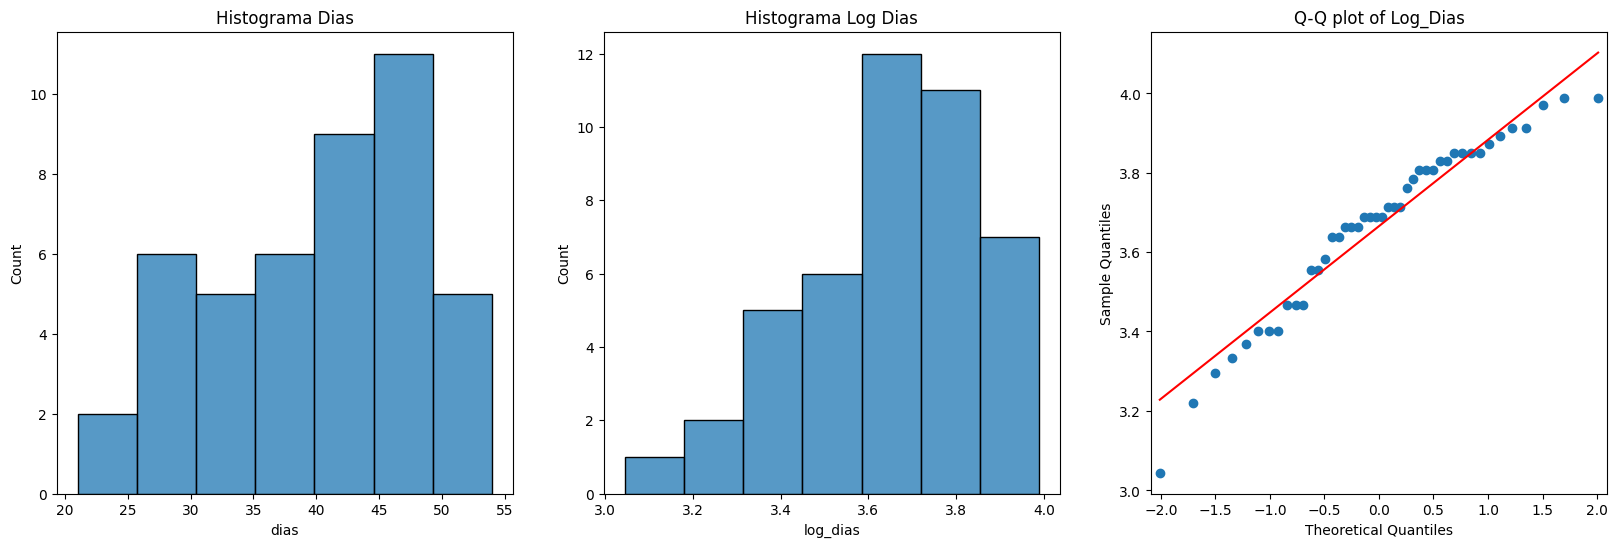

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
sns.histplot(data = X, x = 'dias', ax = ax[0])
ax[0].set_title('Histograma Dias')

sns.histplot(data = X, x = 'log_dias', ax = ax[1])
ax[1].set_title('Histograma Log Dias')

#Trazamos Q-Q Plot para supuesto de ANOVA
sm.qqplot(X.log_dias, line = 's', ax = ax[2])
ax[2].set_title('Q-Q plot of Log_Dias')
plt.show()

In [43]:
ANOVA = ols(formula = "log_dias ~ C(lluvia)", data = X).fit()
print(ANOVA.summary())

sm.stats.anova_lm(ANOVA, typ = 2)

                            OLS Regression Results                            
Dep. Variable:               log_dias   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.178
Date:                Wed, 20 Mar 2024   Prob (F-statistic):             0.0819
Time:                        03:41:28   Log-Likelihood:                 6.2838
No. Observations:                  44   AIC:                            -8.568
Df Residuals:                      42   BIC:                            -4.999
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6150      0.043     84.

,sum_sq,df,F,PR(>F)
C(lluvia),0.146488,1.0,3.177754,0.081877
Residual,1.936119,42.0,NaN,NaN


Vemos que $\text{p-value} > 0.05$, por lo que se acepta la hipótesis $H_0$, de que las medias de los días en los grupos de la variable lluvia son estadísticamente iguales.

Utilicemos la variable de interaccion.

In [44]:
#Dado esto se realiza un modelo lineal solo con la variable de interaccion
#Formula del modelo
ols_formula = 'calidad ~ C(lluvia):dias'

#Eliminamos el año
X = data.drop('cosecha', axis = 1)

#Modelo
OLS = ols(formula = ols_formula, data = X)

#Ajustamos modelo
linear_model2 = OLS.fit()

print(linear_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     41.69
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.32e-10
Time:                        03:41:50   Log-Likelihood:                -49.123
No. Observations:                  44   AIC:                             104.2
Df Residuals:                      41   BIC:                             109.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.6502      0.59

Notamos una clara mejora en los valores de $R^2$ y $R^2$-ajustado, por lo que este modelo explica de mejor manera la varianza de la variable dependiente, además de que la variable de interacción es significativa para el modelo.

Veamos nuevamente los supuestos.

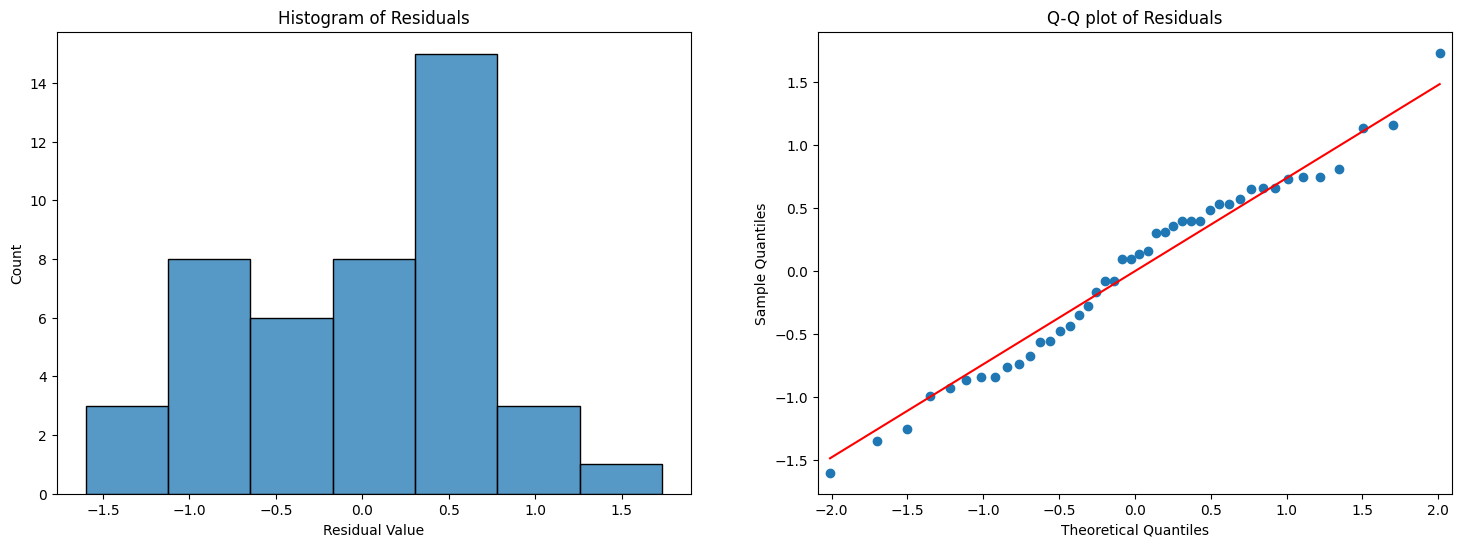

In [45]:
#Veamos el supuesto de Normalidad
#Obtenemos residuos del modelo
residuals = linear_model2.resid

#Trazamos el histograma
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.histplot(residuals, ax = ax[0])
ax[0].set_xlabel('Residual Value')
ax[0].set_title('Histogram of Residuals')


#Trazamos Q-Q Plot
sm.qqplot(residuals, line = 's', ax = ax[1])
ax[1].set_title('Q-Q plot of Residuals')
plt.show()

Notamos que los datos se acercan más a la diagonal en el Q-Q plot que en el caso sin interacción, y es casi normal, por lo que se cumple el supuesto.

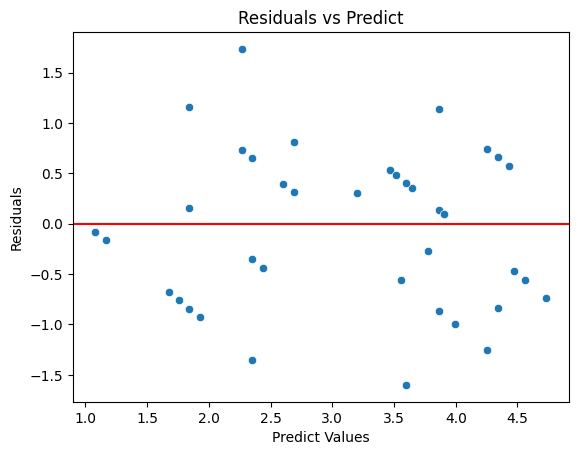

In [46]:
#Veamos el supuesto de Homocedasticidad
#Predecimos los valores con el modelo ajustado
y_predict = linear_model2.predict(X)

#Formamos scatterplot residuos vs valores predichos
fig = sns.scatterplot(x = y_predict, y = residuals)
fig.axhline(0, color = 'r')
fig.set_xlabel('Predict Values')
fig.set_ylabel('Residuals')
fig.set_title('Residuals vs Predict')
plt.show()

Se cumple el supuesto de homocedasticidad, pues la varianza se mantiene.

In [47]:
rmse = mean_squared_error(y_true  = y, y_pred  = y_predict, squared = False)
r2 = r2_score(y_true = y, y_pred = y_predict)
mae = mean_squared_error(y_true  = y, y_pred  = y_predict)
print(f"El error (RMSE) es: {round(rmse, 4)}")
print(f"El error (MAE) es: {round(mae, 4)}")
print(f"El coeficiente de determinación (r2) es: {round(r2, 4)}")

El error (RMSE) es: 0.739
El error (MAE) es: 0.5461
El coeficiente de determinación (r2) es: 0.6704


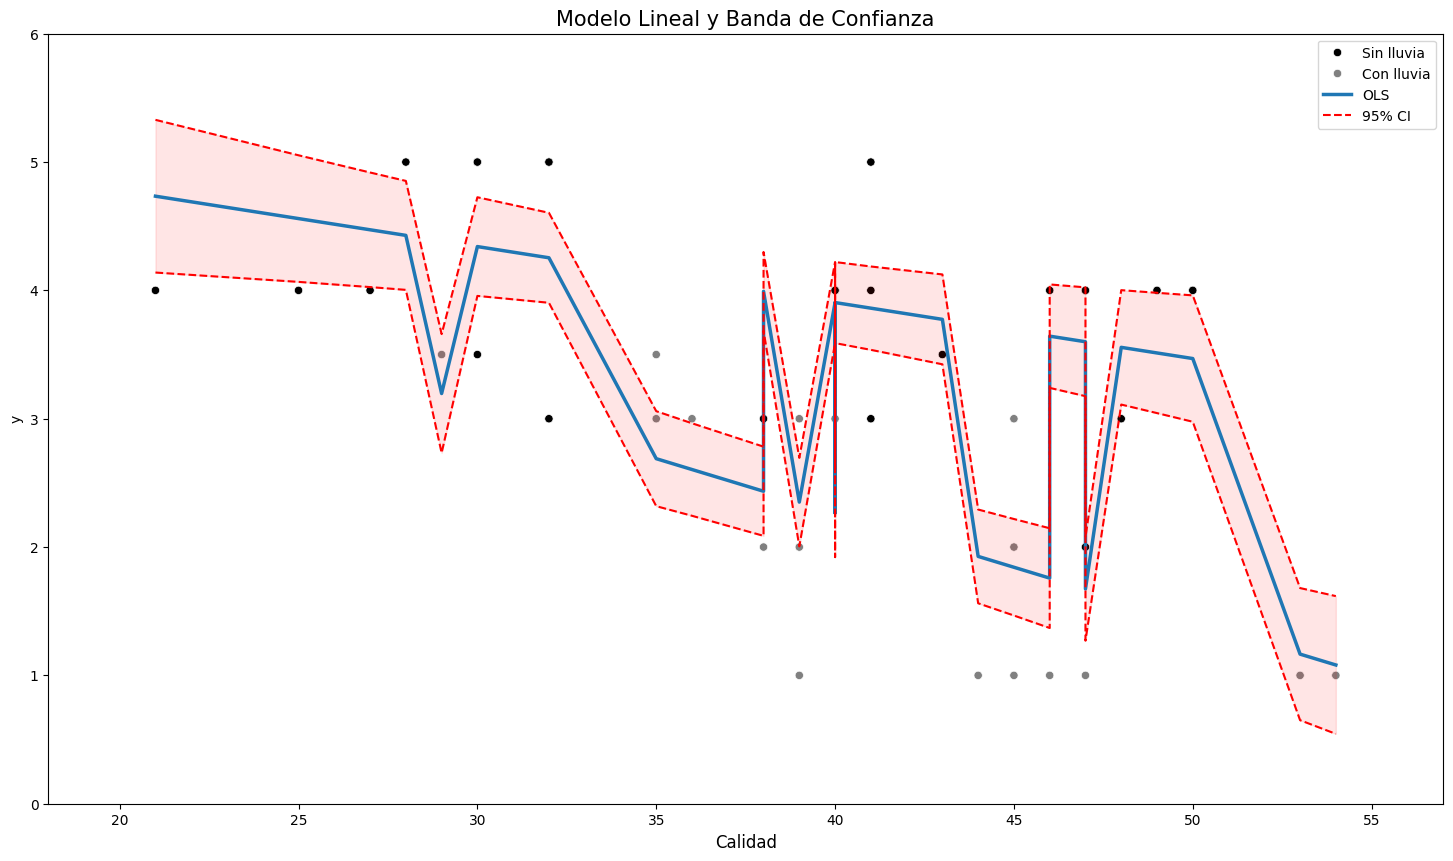

In [48]:
#Plot resultado Calidad vs Dias
confidence_band(linear_model2, X)

8. Conclusiones y recomendaciones a la viña “Condorito” sobre la calidad de la cosecha.


Enfocandonos en el último modelo desarrollado, se puede notar que el intercepto del modelo es de $5.6502$, y que cada día que pasa de cosecha, la calidad va disminuyendo $-0.0436$ o $-0.0846$. Donde estos valores corresponden a la disminución de calidad de la cosecha día a día, en un año que no hay lluvia durante la cosecha y un año donde si la hubo, respectivamente. Es claro entonces, que cuando ocurre el evento de lluvia durante la cosecha la calidad de esta disminuye el doble día a día en comparación a un año donde no hubo lluvia, entonces para que no disminuya la calidad demasiado, es recomendable contratar a mas cosechadores, para que el proceso de cosecha se haga en menor cantidad de tiempo, y la calidad no disminuya tanto.